In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tnrange, tqdm_notebook
import gc
import operator

In [2]:
sns.set_context('talk')

In [3]:
pd.set_option('display.max_columns', 500)

In [4]:
import warnings
warnings.filterwarnings('ignore', message='Changing the shape of non-C contiguous array')

# Read the data

In [5]:
dfXtrain = pd.read_csv('preprocessed_csv/train_4.csv', index_col='id', sep=';')
dfXtest = pd.read_csv('preprocessed_csv/test_4.csv', index_col='id', sep=';')
dfYtrain = pd.read_csv('preprocessed_csv/y_train_4.csv', header=None, names=['ID', 'COTIS'], sep=';')

In [6]:
dfYtrain = dfYtrain.set_index('ID')

# Preprocessing

Вынесем var14, department и subreg.

In [7]:
dropped_col_names = ['subreg', 'ext_dep'] 

def drop_cols(df):
    return df.drop(dropped_col_names, axis=1), df[dropped_col_names]

In [8]:
train, dropped_train = drop_cols(dfXtrain)
test, dropped_test = drop_cols(dfXtest)

Добавим инфу о величине города из subreg'a

In [9]:
def add_big_city_cols(df, dropped_df):
    df['big'] = np.where(dropped_df['subreg'] % 100 == 0, 1, 0)
    df['average'] = np.where(dropped_df['subreg'] % 10 == 0, 1, 0)
    df['average'] = df['average'] - df['big']
    df['small'] = 1 - df['big'] - df['average']
    return df

In [10]:
train = add_big_city_cols(train, dropped_train)
test = add_big_city_cols(test, dropped_test)

Декодируем оставшиеся категориальные признаки

In [11]:
categorical = list(train.select_dtypes(exclude=[np.number]).columns)
categorical

['marque', 'energie_veh', 'profession', 'var6', 'var8', 'var14']

In [12]:
list(test.select_dtypes(exclude=[np.number]).columns)

['marque', 'energie_veh', 'profession', 'var6', 'var8', 'var14']

In [13]:
for col in categorical:
    print(col, train[col].nunique(), test[col].nunique())

marque 154 73
energie_veh 5 5
profession 17 17
var6 5 5
var8 23 19
var14 8 1


energie_veh и var6 с помощью get_dummies

In [14]:
train.energie_veh.unique()

array(['gpl', 'hybride essence', 'electricite', 'gazole', 'essence', nan], dtype=object)

In [15]:
test.energie_veh.unique()

array(['essence', 'gazole', 'gpl', 'hybride essence', nan, 'electricite'], dtype=object)

In [16]:
small_cat = ['energie_veh', 'var6']

In [17]:
train = pd.get_dummies(train, columns=small_cat)
test = pd.get_dummies(test, columns=small_cat)

Теперь посмотрим на остальные

In [18]:
len(set(train.profession.values) - set(test.profession.values))

0

In [19]:
len(set(train.var8.values) - set(test.var8.values))

4

In [20]:
len(set(test.var8.values) - set(train.var8.values))

0

In [21]:
len(set(train.marque.values) - set(test.marque.values))

83

In [22]:
len(set(test.marque.values) - set(train.marque.values))

2

In [23]:
set(test.marque.values) - set(train.marque.values)

{'GEELY', 'SOVAM'}

In [24]:
test[test.marque == 'GEELY']

,marque,puis_fiscale,anc_veh,kmage_annuel,crm,profession,var1,var2,var3,var4,var5,var7,var8,var9,var10,var11,var13,var14,var15,var16,var17,var18,var19,var20,var21,var22,department,age,big,average,small,energie_veh_electricite,energie_veh_essence,energie_veh_gazole,energie_veh_gpl,energie_veh_hybride essence,var6_A,var6_B,var6_C,var6_D,var6_N
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
305916,GEELY,5,0,7421,50,technicien,6.0,3,272,0,1,1.0,M1,94,150,0,4,N,2,4.0,1,20,0,1,1,4,1,25.0,0,0,1,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [25]:
test[test.marque == 'SOVAM']

,marque,puis_fiscale,anc_veh,kmage_annuel,crm,profession,var1,var2,var3,var4,var5,var7,var8,var9,var10,var11,var13,var14,var15,var16,var17,var18,var19,var20,var21,var22,department,age,big,average,small,energie_veh_electricite,energie_veh_essence,energie_veh_gazole,energie_veh_gpl,energie_veh_hybride essence,var6_A,var6_B,var6_C,var6_D,var6_N
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
318867,SOVAM,9,19,17000,50,"agent, employe",28.0,5,372,7,1,20.0,K2,0,0,19,5,N,3,1.0,1,19,0,0,1,0,974,47.0,0,0,1,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


profession и var8 тоже в dummy

In [26]:
middle_cat = ['profession', 'var8', 'marque', 'var14', 'department']

In [27]:
bigX = pd.concat([train, test])

In [28]:
bigX.shape

(330000, 41)

In [29]:
bigX = pd.get_dummies(bigX, columns=middle_cat)

In [30]:
bigX.shape

(330000, 338)

In [31]:
bigX.fillna(-9999, inplace=True)

Расположим столбцы в нужном порядке

In [32]:
bigX.crm /= 100

In [33]:
first_col_list = ['crm', 'puis_fiscale']
col_list = first_col_list + sorted(list(set(bigX.columns) - set(first_col_list)))

In [34]:
bigX = bigX[col_list]

In [35]:
y_train = np.array(dfYtrain)
train = bigX.loc[train.index]
x_train = np.array(train)
test = bigX.loc[test.index]
x_test = np.array(test)

In [36]:
x_train.shape

(300000, 338)

In [37]:
x_test.shape

(30000, 338)

# Save routines

In [38]:
dfYtest = pd.DataFrame({'ID': dfXtest.index, 'COTIS': np.zeros(test.shape[0])})
dfYtest = dfYtest[['ID', 'COTIS']]
dfYtest.head()

,ID,COTIS
0,300001,0.0
1,300002,0.0
2,300003,0.0
3,300004,0.0
4,300005,0.0


In [39]:
def save_to_file(y, file_name):
    dfYtest['COTIS'] = y
    dfYtest.to_csv('results/{}'.format(file_name), index=False, sep=';')

In [40]:
model_name = 'ldtr'
dfYtest_stacking = pd.DataFrame({'ID': dfXtrain.index, model_name: np.zeros(train.shape[0])})
dfYtest_stacking = dfYtest_stacking[['ID', model_name]]
dfYtest_stacking.head()

,ID,ldtr
0,1,0.0
1,2,0.0
2,3,0.0
3,4,0.0
4,5,0.0


In [41]:
def save_to_file_stacking(y, file_name):
    dfYtest_stacking[model_name] = y
    dfYtest_stacking.to_csv('stacking/{}'.format(file_name), index=False, sep=';')

# Train model

In [42]:
def plot_quality(grid_searcher, param_name):
    means = []
    stds = []
    for elem in grid_searcher.grid_scores_:
        means.append(np.mean(elem.cv_validation_scores))
        stds.append(np.sqrt(np.var(elem.cv_validation_scores)))
    means = np.array(means)
    stds = np.array(stds)
    
    params = grid_searcher.param_grid
    
    plt.figure(figsize=(10, 6))
    plt.plot(params[param_name], means)
    plt.fill_between(params[param_name], \
                 means + stds, means - stds, alpha = 0.3, facecolor='blue')
    plt.xlabel(param_name)
    plt.ylabel('MAPE')

In [43]:
def mape(y_true, y_pred): 
    return -np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [44]:
def mape_scorer(est, X, y):
    gc.collect()
    return mape(y, est.predict(X))

In [45]:
class MyGS():
    class Element():
        def __init__(self):
            self.cv_validation_scores = []
        
        
        def add(self, score):
            self.cv_validation_scores.append(score)
    
    
    def __init__(self, param_grid, name, n_folds):
        self.param_grid = {name: param_grid}
        self.grid_scores_ = [MyGS.Element() for item in param_grid]
        
    
    def add(self, score, param_num):
        self.grid_scores_[param_num].add(score)
        

In [46]:
validation_index = (dropped_train.ext_dep == 10) | (dropped_train.ext_dep > 900)
train_index = ~validation_index

In [47]:
subtrain, validation = train[train_index], train[validation_index]
x_subtrain = np.array(subtrain)
x_validation = np.array(validation)

ysubtrain, yvalidation = dfYtrain[train_index], dfYtrain[validation_index]
y_subtrain = np.array(ysubtrain).flatten()
y_validation = np.array(yvalidation).flatten()

In [48]:
validation.shape

(33155, 338)

In [49]:
from sklearn.tree import LinearDecisionTreeRegressor as LDTR

In [50]:
from sklearn.tree import DecisionTreeRegressor

In [51]:
from sklearn.ensemble import ExtraTreesRegressor

In [52]:
%%time
est = ExtraTreesRegressor(n_estimators=10, max_features=None, 
                          max_depth=None, n_jobs=-1, random_state=42).fit(
    X=x_subtrain, y=np.log(y_subtrain), sample_weight=None)

CPU times: user 4min 43s, sys: 432 ms, total: 4min 44s
Wall time: 1min 22s


In [53]:
y_pred = est.predict(x_validation)
mape(y_validation, np.exp(y_pred))

-10.462640926958898

In [57]:
gc.collect()

9

In [58]:
sample_weight_subtrain = np.power(y_subtrain, -1)

In [59]:
%%time
est = DecisionTreeRegressor(max_features=None, 
                          max_depth=None, random_state=42).fit(
    X=x_subtrain, y=np.log(y_subtrain), sample_weight=sample_weight_subtrain)

CPU times: user 26 s, sys: 108 ms, total: 26.1 s
Wall time: 26.1 s


In [60]:
y_pred = est.predict(x_validation)
mape(y_validation, np.exp(y_pred))

-13.680697423224714

In [63]:
gc.collect()

9

In [64]:
sample_weight_subtrain = np.power(y_subtrain, -1)

In [65]:
%%time
est = LDTR(max_features=None, max_depth=15, random_state=42,
           n_coefficients=2, n_first_dropped=2, const_term=True, min_samples_leaf=40).fit(
    X=x_subtrain, y=y_subtrain, sample_weight=sample_weight_subtrain)

CPU times: user 20.8 s, sys: 48 ms, total: 20.8 s
Wall time: 20.8 s


In [66]:
y_pred = est.predict(x_validation)
mape(y_validation, y_pred)

-9.9656483078445497

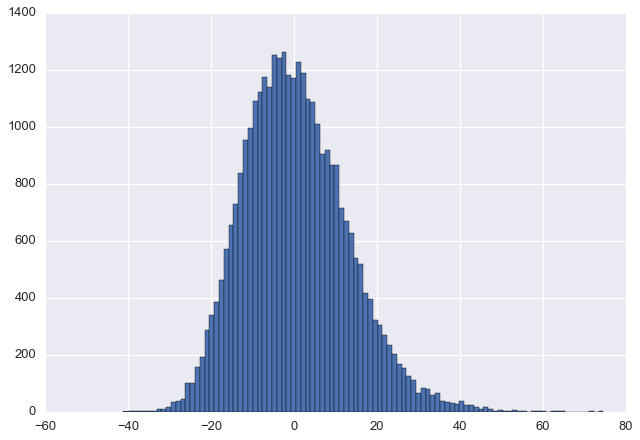

In [67]:
plt.hist(100 * (y_pred - y_validation) / y_validation , bins=100)
plt.show()

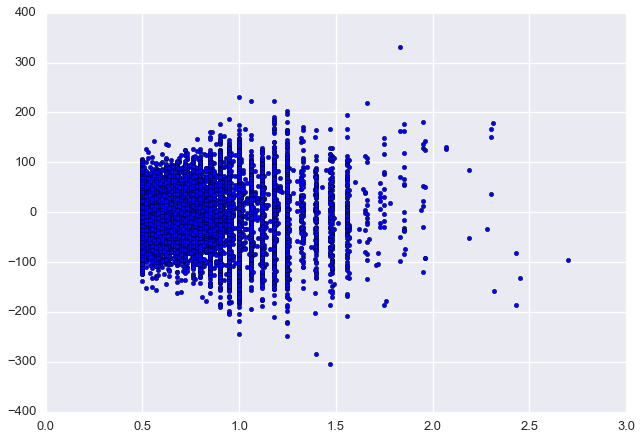

In [68]:
plt.scatter(x_validation[:, 0], y_pred - y_validation)
#plt.scatter(x_validation[:, 0], y_validation, color='g')
plt.show()

In [69]:
%%time
est = LDTR(max_features=None, max_depth=15, random_state=42,
           n_coefficients=2, n_first_dropped=2, const_term=True, min_samples_leaf=40).fit(
    X=x_subtrain, y=y_subtrain, sample_weight=sample_weight_subtrain)

CPU times: user 20.6 s, sys: 64 ms, total: 20.6 s
Wall time: 20.6 s


In [70]:
y_pred = est.predict(x_validation)
mape(y_validation, y_pred)

-9.9656483078445497

In [71]:
sample_weight_subtrain = np.power(y_subtrain, -1)

In [72]:
from sklearn.ensemble import BaggingRegressor

In [73]:
gc.collect()

21694

In [74]:
ldtr = LDTR(max_features=None, max_depth=None,
           n_coefficients=2, n_first_dropped=2, const_term=True, min_samples_leaf=20)

In [75]:
%%time
est = BaggingRegressor(base_estimator=ldtr, n_estimators=50, max_samples=1.0,
                       n_jobs=-1, random_state=42).fit(
            X=x_subtrain, y=y_subtrain, sample_weight=sample_weight_subtrain)

CPU times: user 5.91 s, sys: 1.48 s, total: 7.39 s
Wall time: 8min 36s


In [76]:
y_pred = est.predict(x_validation)
mape(y_validation, y_pred)

-9.3783857225169456

In [77]:
scores = []
coeffs = np.array(np.arange(0.9, 1.1, 0.01))
for coeff in coeffs:
    scores.append(mape(y_validation, coeff * y_pred))

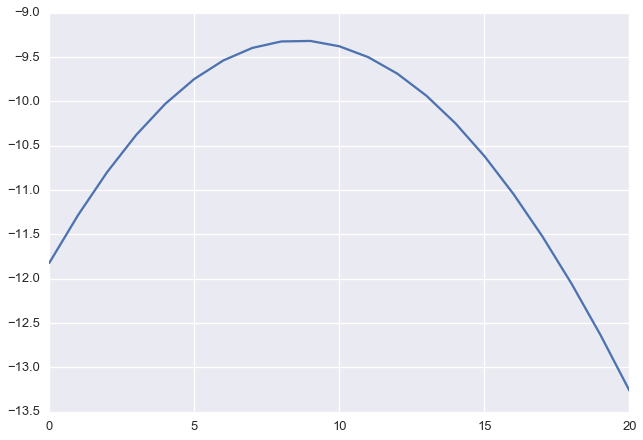

In [78]:
plt.plot(scores)

# Save

In [144]:
%%time
est = LDTR(max_features=None, max_depth=15, random_state=42,
           n_coefficients=2, n_first_dropped=2, const_term=True, min_samples_leaf=40).fit(
    X=x_train, y=y_train, sample_weight=np.power(y_train.flatten(), -1))

CPU times: user 19 s, sys: 248 ms, total: 19.2 s
Wall time: 19.3 s


In [145]:
y_pred = est.predict(x_test)

In [146]:
save_to_file(y_pred, 'ldtr.csv')